In [ ]:
!python -m spacy download en_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 11.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-man

In this notebook we will preprocess the dataset `News_Category_Dataset_v3.csv` and create two new datasets:
- `dataset_v1.csv` with stop words saved
- `dataset_v2.csv` with stop words removed

In [ ]:
import spacy
import pandas as pd

df = pd.read_csv('News_Category_Dataset_v3.csv')

df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [ ]:
df.isna().sum()

link                     0
headline                 1
category                 0
short_description        0
authors              32955
date                     0
dtype: int64

In [ ]:
df = df.fillna('')

In [ ]:
nlp = spacy.load('en_core_web_trf')

In [ ]:
import re
from tqdm import tqdm
from typing import Optional

def preprocess_dataset(df: pd.DataFrame, remove_stop_words: Optional[bool] = True) -> pd.DataFrame:
    """
    Function that merges headlines with descriptions
    and removes numbers, stop words and punctuation symbols in the merged data

    :param df: dataframe with news
    :param remove_stop_words: whether to remove stop words
    :return: same dataframe but with new descriptions
    """
    # change description data
    response = df.copy(deep=True)
    pairs = zip(df.headline.values, df.short_description.values)
    response.short_description = [
        re.sub('\s+', ' ', f'{headline}\n{description}').strip()
        for headline, description in pairs
    ]
    # list for the new descriptions
    processed_descriptions = []

    # ignore numbers and punctuation symbols
    if remove_stop_words:
        # also ignore stop words
        criterion = lambda token: not any((token.is_digit, token.is_stop, token.is_punct))
    else:
        criterion = lambda token: not any((token.is_digit, token.is_punct))

    # dataframe cleaning process
    for description in tqdm(df.short_description.values):
        doc = nlp(description)
        processed_tokens = [token.lemma_ for token in filter(criterion, doc)]
        processed_description = ' '.join(processed_tokens)

        processed_descriptions.append(processed_description)

    # replace old data
    response.short_description = processed_descriptions

    return response

In [ ]:
from sklearn.model_selection import train_test_split

dataset, _, _, _ = train_test_split(df, df.category, stratify=df.category, train_size=0.1, random_state=42)
len(dataset)

18981

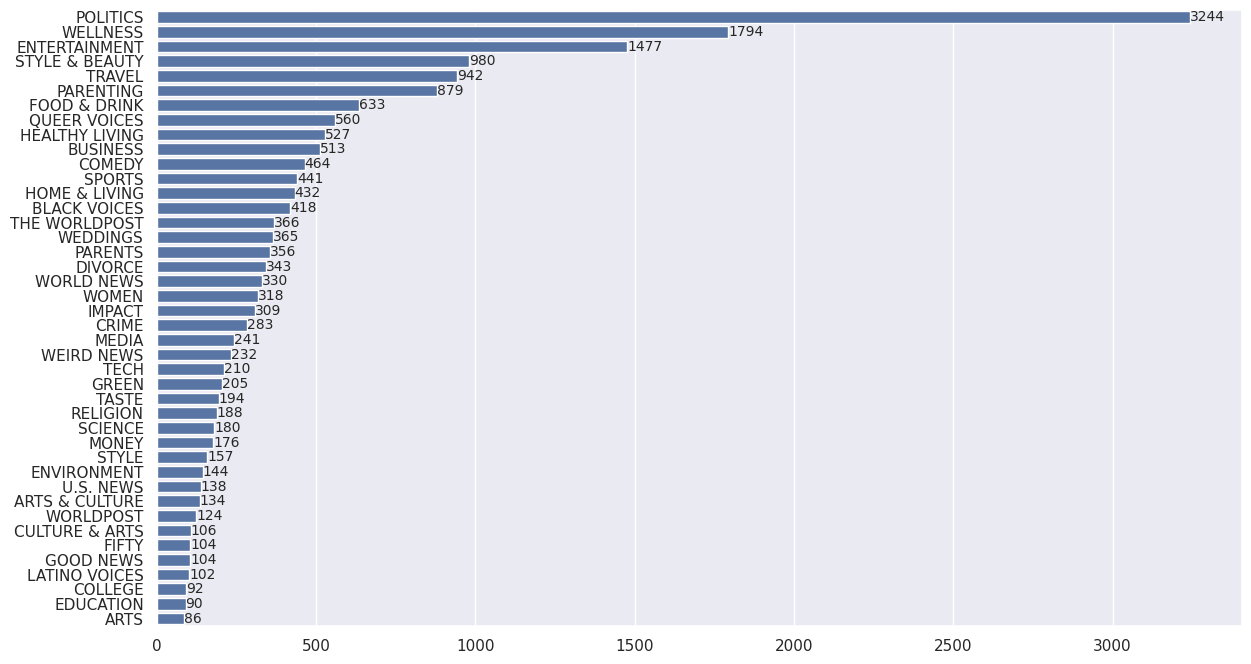

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

counts = dataset.category.value_counts()
plt.figure(figsize=(14, 8))
ax = sns.barplot(y=counts.index, x=counts.values, orient='h')
ax.bar_label(ax.containers[0], fontsize=10)
plt.ylabel('')
plt.xlabel('')
plt.show()

In [ ]:
dataset_v1 = preprocess_dataset(dataset, False)
dataset_v1.to_csv('dataset_v1.csv', index=False)

100%|██████████| 18981/18981 [1:14:26<00:00,  4.25it/s]


In [ ]:
dataset_v2 = preprocess_dataset(dataset)
dataset_v2.to_csv('dataset_v2.csv', index=False)

100%|██████████| 18981/18981 [57:39<00:00,  5.49it/s]
